In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn

from sklearn.cluster import KMeans



from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from torch.nn import Sequential as Seq

from tqdm import tqdm

sys.path.append('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation')
from onegraph_rest_free_graphds import OneGraphDS
from gan_based_models import Discriminator
from second_stage_vig_based_models import FullModel
from vig_based_functions import act_layer, get_multi_shot_set
from vig_graph_modules import GrapherSetEdges, FFN
from perceptual_loss import VGGPerceptualLoss

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing f

In [2]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_pokemon_unsup.pickle"

with open(SAVE_PATH, 'rb') as handle:
    data = pickle.load(handle)

train_tiles = data["train_tiles"]
test_tiles = data["test_tiles"]
train_cluster = data["train_cluster"]
test_cluster = data["test_cluster"]
cluster_dists = data["train_cluster_dists"]
te_cluster_dists = data["test_cluster_dists"]

print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(cluster_dists.shape)
print(te_cluster_dists.shape)

torch.Size([549, 224, 224, 3])
torch.Size([188, 224, 224, 3])
torch.Size([549])
torch.Size([188])
torch.Size([549, 9])
torch.Size([188, 9])


# Data Pre-process:

In [2]:
data_path = "/home/paulraae/MS_Thesis_Data/pokedata/PokemonData.csv"
data = pd.read_csv(data_path)

In [3]:
data_path = "/home/paulraae/MS_Thesis_Data/pokedata/pokemon_jpg"
poke_database = {"number":None, "image":None}
i_tensor = []
n_tensor = []
for i in os.listdir(data_path):
    img = os.path.join(data_path,i)
    #print(i.split(".")[0])
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = np.array(img)
    img = img/255
    #plt.imshow(img)
    img = torch.Tensor(np.array(img))
    #plt.imshow(img.detach().cpu().numpy())
    i_tensor.append(img)
    n_tensor.append(''.join([char for char in i.split(".")[0].split("-")[0] if char.isdigit()]))
    #print(img.shape)
    #plt.show()

poke_database["image"] = torch.stack(i_tensor)
poke_database["number"] = torch.Tensor(np.array(n_tensor).astype(np.int32)).to(torch.int)

In [4]:
sorted_indices = torch.argsort(poke_database["number"])
poke_database["number"] = poke_database["number"][sorted_indices]
poke_database["image"]  = poke_database["image"] [sorted_indices]

In [5]:
poke_database["image"].shape

torch.Size([796, 224, 224, 3])

In [6]:
data = data.head(736)

In [7]:
data.head()

,Num,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [7]:
names = data["Name"]

In [9]:
names.shape

(736,)

In [8]:
poke_database["image"] = poke_database["image"][:737]
poke_database["number"] = poke_database["number"][:737]

In [9]:
print(poke_database["image"].shape)
print(poke_database["number"].shape)

torch.Size([737, 224, 224, 3])
torch.Size([737])


In [12]:
from IPython.display import clear_output

n = 736
for i in range(names.shape[0])[n:]:
    print(i)
    print(names[i])
    plt.imshow(poke_database["image"][i])
    plt.show()
    input()
    clear_output(wait=True)

## Data

In [10]:
train_tiles = poke_database["image"]
#x = train_tiles.reshape(B,-1)
train_tiles.shape

torch.Size([737, 224, 224, 3])

In [11]:
x = poke_database["image"].reshape(poke_database["image"].shape[0], -1)
x.shape

torch.Size([737, 150528])

In [27]:
x = poke_database["image"].reshape(poke_database["image"].shape[0], -1)
kmeans = KMeans(n_clusters=9)
kmeans.fit(x)

train_tiles_clusters = torch.Tensor(kmeans.labels_).to(torch.int)

unique, counts = np.unique(train_tiles_clusters, return_counts=True)

print(counts)
print(train_tiles.shape)
print(train_tiles_clusters.shape)

[135  59  20  29  78 107 121 125  63]
torch.Size([737, 224, 224, 3])
torch.Size([737])


In [28]:
centroids = torch.Tensor(kmeans.cluster_centers_).reshape(9,224,224,3)

In [29]:
unique, counts = np.unique(train_tiles_clusters, return_counts=True)

print(counts)
print(train_tiles.shape)
print(train_tiles_clusters.shape)

[135  59  20  29  78 107 121 125  63]
torch.Size([737, 224, 224, 3])
torch.Size([737])


In [30]:
train_counts=np.array(np.floor(counts*0.75), dtype=np.int64)
print(train_counts)
print(train_counts.sum())
print(counts - train_counts)
print((counts - train_counts).sum())
print((train_counts+(counts-train_counts)) == counts)

[101  44  15  21  58  80  90  93  47]
549
[34 15  5  8 20 27 31 32 16]
188
[ True  True  True  True  True  True  True  True  True]


In [31]:
rng = np.random.default_rng()
test_ind = []
train_ind = []
unique, counts = np.unique(train_tiles_clusters, return_counts=True)

for cluster, count in zip(np.unique(train_tiles_clusters), train_counts):
    main_array = np.where(train_tiles_clusters == cluster)[0]
    train_values = rng.choice(main_array, size=count, replace=False)
    test_values = np.setdiff1d(main_array, train_values)
    
    train_ind.extend(train_values)
    test_ind.extend(test_values)

train_ind = np.array(train_ind)
test_ind = np.array(test_ind)
    

In [32]:
print(train_ind.shape)
print(test_ind.shape)

(549,)
(188,)


In [33]:
test_tiles = train_tiles[test_ind]
train_tiles = train_tiles[train_ind]

train_cluster = train_tiles_clusters[train_ind]
test_cluster = train_tiles_clusters[test_ind]

print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)

torch.Size([549, 224, 224, 3])
torch.Size([188, 224, 224, 3])
torch.Size([549])
torch.Size([188])


In [34]:
#n+=1
#print(n)
#print("Cluster:",train_cluster[n].item())
cluster_dists = []
with torch.no_grad():
    for tiles in train_tiles:
        aux = []
        for centroid in centroids:
            aux.append(torch.dist(tiles, centroid, p=2))
        aux = torch.Tensor(aux)
        cluster_dists.append(aux)
    cluster_dists = torch.stack(cluster_dists)

cluster_dists = (cluster_dists - torch.min(cluster_dists))/(torch.max(cluster_dists) - torch.min(cluster_dists))

In [35]:
#n+=1
#print(n)
#print("Cluster:",train_cluster[n].item())
te_cluster_dists = []
with torch.no_grad():
    for tiles in test_tiles:
        aux = []
        for centroid in centroids:
            aux.append(torch.dist(tiles, centroid, p=2))
        aux = torch.Tensor(aux)
        te_cluster_dists.append(aux)
    te_cluster_dists = torch.stack(te_cluster_dists)

te_cluster_dists = (te_cluster_dists - torch.min(te_cluster_dists))/(torch.max(te_cluster_dists) - torch.min(te_cluster_dists))

In [36]:
cluster_dists.shape

torch.Size([549, 9])

In [37]:
print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(cluster_dists.shape)
print(te_cluster_dists.shape)

torch.Size([549, 224, 224, 3])
torch.Size([188, 224, 224, 3])
torch.Size([549])
torch.Size([188])
torch.Size([549, 9])
torch.Size([188, 9])


In [38]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_pokemon_unsup.pickle"
data = {"train_tiles":train_tiles, "test_tiles":test_tiles, "train_cluster":train_cluster, "test_cluster":test_cluster, "train_cluster_dists":cluster_dists, "test_cluster_dists":te_cluster_dists}
with open(SAVE_PATH, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Models

In [ ]:
class DiscDownBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
      super().__init__()
      self.convs = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
      )

    def forward(self, x):
      return self.convs(x)
    
class DiscStrideBlock(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.convs = nn.Sequential(
      nn.Conv2d(in_dim, in_dim, 3, stride=1, padding=1),
      nn.BatchNorm2d(in_dim),
      nn.ReLU(True),
    )

  def forward(self, x):
    return self.convs(x)

class DiscBlock(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.down = DiscDownBlock(in_dim, out_dim)
    self.stride = DiscStrideBlock(out_dim)

  def forward(self, x):
    x = self.down(x)
    return self.stride(x)

class GenBlock(nn.Module):
  def __init__(self, in_dim = 128, out_dim = 3):
      super(GenBlock, self).__init__()

      self.model = nn.Sequential(
          nn.ConvTranspose2d(in_dim, out_dim, 3, 1, 1),
          nn.BatchNorm2d(out_dim),
          nn.ReLU(True),
      )

  def forward(self, x):
      x = self.model(x)
      return x
    
class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim, num_cats):
      super().__init__()
      self.block1 = DiscBlock(in_dim, out_dim//16)
      self.block2 = DiscBlock(out_dim//16, out_dim//8)
      self.block3 = DiscBlock(out_dim//8, out_dim//4)
      self.block4 = DiscBlock(out_dim//4, out_dim//2)
      self.block5 = DiscBlock(out_dim//2, out_dim)

      self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(out_dim*7*7, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(True),
        nn.Linear(8192, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, num_cats),
        nn.Sigmoid(),
      )
      
      self.gen_block1 = GenBlock(out_dim, out_dim//2)
      self.gen_block2 = GenBlock(out_dim//2, out_dim//4)
      self.gen_block3 = GenBlock(out_dim//4, out_dim//8)
      self.gen_block4 = GenBlock(out_dim//8, out_dim//16)
      self.gen_block5 = GenBlock(out_dim//16, out_dim//16)
      self.gen_out = nn.Sequential(
        nn.Conv2d(out_dim//16, in_dim, 1, 1),
        nn.Sigmoid(),
      )

    def forward(self, x):
      x1 = self.block1(x)
      x2 = self.block2(x1)
      x3 = self.block3(x2)
      x4 = self.block4(x3)
      x5 = self.block5(x4)
      
      x = self.classifier(x5)
      
      gx1 = self.gen_block1(x5)
      gx2 = self.gen_block2(gx1)
      gx3 = self.gen_block3(gx2)
      gx4 = self.gen_block4(gx3)
      gx5 = self.gen_block5(gx4)
      
      out = self.gen_out(gx5)
      
      return [x1,x2,x3,x4,x5], [gx1,gx2,gx3,gx4,gx5], x, out

In [5]:
class DetectorBlock(nn.Module):
  def __init__(self, out_dim, img_size):
    super().__init__()
    self.linear = nn.Sequential(
      nn.Flatten(),
      nn.Linear(out_dim*(img_size//2)*(img_size//2), 8192),
      nn.BatchNorm1d(8192),
      nn.ReLU(True),
    )

  def forward(self, x):
    return self.linear(x)
    
class Detector(nn.Module):
    def __init__(self, in_dim, out_dim, num_cats ,num_patches = 3, stride = 14, img_size=224, device="cuda:7"):
      super().__init__()
      self.block1 = DetectorBlock(out_dim//16, img_size)
      self.block2 = DetectorBlock(out_dim//8, img_size//2)
      self.block3 = DetectorBlock(out_dim//4, img_size//4)
      self.block4 = DetectorBlock(out_dim//2, img_size//8)
      self.block5 = DetectorBlock(out_dim, img_size//16)
      
      self.regressor = nn.Sequential(
        nn.Linear(8192*5, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(True),
        nn.Linear(8192, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, num_patches*2),
        #nn.Sigmoid()
      )
      self.classifier = Discriminator(in_dim, out_dim, num_cats)
      self.stride = stride
      self.device = device

    def forward(self, x, x_in):
      B,C,H,W = x[0].shape
      x1 = self.block1(x[0])
      x2 = self.block2(x[1])
      x3 = self.block3(x[2])
      x4 = self.block4(x[3])
      x5 = self.block5(x[4])
      
      x = torch.cat([x1,x2,x3,x4,x5], dim=1)
      
      x1 = self.regressor(x)
      x1 = (x1 - torch.min(x1))/(torch.max(x1) - torch.min(x1))
      
      base = torch.ones(B,224,224,3)
      #base = (base - torch.min(base))/(torch.max(base) - torch.min(base))
      i=-1
      for b,xx in zip(base,x1):
        i+=1
        for o in xx.reshape(-1,2):
          x_min = int(o[0] * 224)
          y_min = int(o[1] * 224)
          x_max = x_min+self.stride
          y_max = y_min+self.stride
          b[x_min:x_max, y_min:y_max] = x_in[i].reshape(224,224,3)[x_min:x_max, y_min:y_max]
      
      base = base.to(self.device)

      out_conv, gx2, x, img= self.classifier(base.reshape(B,3,224,224))
      return x1, gx2, base, out_conv, x, img

In [163]:
EPOCHS = 500
BATCH_SIZE = 100
DEVICE = "cuda:6" if torch.cuda.is_available() else "cpu"

In [164]:
LR = 0.0001
model = Discriminator(3, 512, 9)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss = nn.MSELoss()

In [165]:
EPOCHS = 1500

In [166]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)

    train_index = train_index.T[:500].reshape(-1,BATCH_SIZE)
    i=0
    
    model.train()
    for tr_ind in train_index:
        i+=1
        torch.cuda.empty_cache()
        
        x = train_tiles[tr_ind]
        x = x.to(DEVICE)
        y = cluster_dists[tr_ind]
        
        x_in = x.reshape(-1,3,224,224)
        y = y.to(DEVICE)
        x_in = x_in.to(DEVICE)
        
        conv, tconv, pred, img_pred = model(x_in)
        #conv, tconv, img_pred = model(x_in)
        
        pl = loss(pred,y)
        #del pred, y
        del y
        
        pl += loss(img_pred, x_in)
        
        del x, x_in, img_pred
        
        optimizer.zero_grad()
        pl.backward()
        optimizer.step()
        
        running_loss += pl.item()
    
    
    model.eval()
    with torch.no_grad():
        
        x = test_tiles.to(DEVICE)
        x = x.to(DEVICE)
        y = te_cluster_dists
        
        x_in = x.reshape(-1,3,224,224)
        x_in = x_in.to(DEVICE)
        y = y.to(torch.long).to(DEVICE)
        
        conv, tconv, pred, img_pred = model(x_in)
        #conv, tconv, img_pred = model(x_in)
        
        tl = loss(pred,y)
        #del pred, y
        del y
        
        tl += loss(img_pred, x_in)
        
        del x, x_in, img_pred
    
    
    print("Train Loss:", running_loss/i)
    print("Test Loss:", tl.item())
    print()
    del pl, tl
        
        

Epoch: 0


Train Loss: 0.15239571332931517
Test Loss: 0.3818120062351227

Epoch: 1
Train Loss: 0.15651123225688934
Test Loss: 0.30178210139274597

Epoch: 2
Train Loss: 0.12479631304740905
Test Loss: 0.2281607687473297

Epoch: 3
Train Loss: 0.1143075555562973
Test Loss: 0.19999068975448608

Epoch: 4


KeyboardInterrupt: 

In [146]:
n=0

55
tensor(0, dtype=torch.int32)


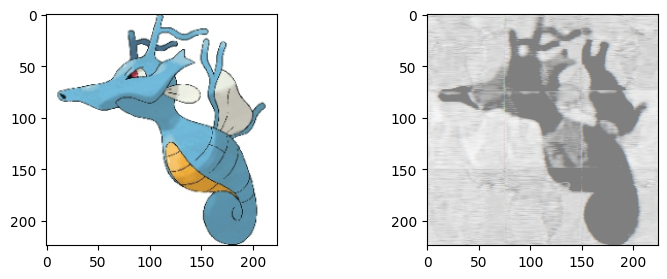

0.029049109667539597
1.1601937330851797e-05
tensor([0.2740, 0.3480, 0.4499, 0.4188, 0.3116, 0.3385, 0.3014, 0.2868, 0.4441])
tensor([0.2736, 0.3553, 0.4471, 0.4196, 0.3090, 0.3418, 0.3037, 0.2846, 0.4477],
       device='cuda:6')


In [162]:
n+=5
model.eval()
print(n)
with torch.no_grad():
    in_img = train_tiles[n].reshape(3,224,224).unsqueeze(0).to(DEVICE)
    conv, _, pred, img_pred = model(in_img)
    #conv, _, img_pred = model(in_img)

    fig, axes = plt.subplots(1, 2, figsize=(9, 3))

    axes[0].imshow(in_img[0].reshape(224,224,3).detach().cpu().numpy())
    
    axes[1].imshow(img_pred[0].reshape(224,224,3).detach().cpu().numpy())
    
    print(train_cluster[n])
    plt.show()
    print(loss(img_pred, in_img).item())
    print(loss(pred, cluster_dists[n].to(DEVICE)).item())
    print(cluster_dists[n])
    print(pred[0])

In [64]:
print(in_img.shape)
print(img_pred.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [87]:
for p in model.parameters():
    p.requires_grad = False

In [88]:
o_model = Detector(3, 512, 9, 12, 28, 224, DEVICE)
o_model = o_model.to(DEVICE)

In [89]:
EPOCHS = 1500
O_LR = 0.00005
o_optimizer = torch.optim.Adam(o_model.parameters(), lr = O_LR)

In [100]:
for epoch in range(EPOCHS):
    model.eval()
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)

    train_index = train_index.T[:500].reshape(-1,BATCH_SIZE)
    i=0
    
    o_model.train()
    for tr_ind in train_index:
        i+=1
        torch.cuda.empty_cache()
        
        x = train_tiles[tr_ind]
        
        x = x.reshape(-1,3,224,224)
        x = x.to(DEVICE)
        
        y = cluster_dists[tr_ind]
        y = y.to(DEVICE)
        
        conv, _, pred, img_pred = model(x)
        
        _, _, _, conv2, pred2, img_pred2 = o_model(conv, x)
        
        pl = 2*loss(pred2,y)
        pl += loss(pred2,pred)
        
        del y
        
        #for x,y in zip(conv2, conv):
        #    pl += 0.15 * loss(x, y)
        
        pl += loss(img_pred2,img_pred)
        pl += loss(img_pred2,x)
        
        del pred, pred2, conv, conv2, img_pred, img_pred2, x
        
        o_optimizer.zero_grad()
        pl.backward()
        o_optimizer.step()
        
        running_loss += pl.item()
    
    
    o_model.eval()
    with torch.no_grad():
        
        x = test_tiles
        y = te_cluster_dists
        y=y.to(DEVICE)
        
        x = x.reshape(-1,3,224,224).to(DEVICE)
        
        conv, _, pred, img_pred = model(x)
        
        _, _, _, conv2, pred2, img_pred2 = o_model(conv, x)
        
        tl = 2*loss(pred2,y)
        tl += loss(pred2,pred)
        
        del y
        
        #for x,y in zip(conv2, conv):
        #    tl += 0.15 * loss(x, y)
        
        tl += loss(img_pred2,img_pred)
        tl += loss(img_pred2,x)
        
        del pred, pred2, conv, conv2, img_pred, img_pred2, x
        
    
    
    print("Train Loss:", running_loss/i)
    print("Test Loss:", tl.item())
    print()
    del pl, tl
        
        

Epoch: 0


Train Loss: 0.08052943348884582
Test Loss: 0.13860872387886047

Epoch: 1
Train Loss: 0.08234707862138749
Test Loss: 0.13668861985206604

Epoch: 2
Train Loss: 0.080918288230896
Test Loss: 0.1326564997434616

Epoch: 3
Train Loss: 0.08013072460889817
Test Loss: 0.1347760111093521

Epoch: 4
Train Loss: 0.08207733482122422
Test Loss: 0.13268625736236572

Epoch: 5
Train Loss: 0.07987077683210372
Test Loss: 0.12909922003746033

Epoch: 6
Train Loss: 0.08451461941003799
Test Loss: 0.13279789686203003

Epoch: 7
Train Loss: 0.08214635252952576
Test Loss: 0.1320953071117401

Epoch: 8
Train Loss: 0.08010132610797882
Test Loss: 0.12652425467967987

Epoch: 9
Train Loss: 0.0794217273592949
Test Loss: 0.133029505610466

Epoch: 10
Train Loss: 0.07902804464101791
Test Loss: 0.13280253112316132

Epoch: 11
Train Loss: 0.07855886667966842
Test Loss: 0.13504904508590698

Epoch: 12
Train Loss: 0.07838211208581924
Test Loss: 0.13557036221027374

Epoch: 13
Train Loss: 0.07814921140670776
Test Loss: 0.1316503584

KeyboardInterrupt: 

In [91]:
n=0

100
tensor([[0.2858, 0.0000, 0.3325, 0.9083, 0.5240, 0.4218, 0.8323, 0.4280, 0.7176,
         0.7269, 0.6239, 0.0646, 0.0932, 0.2106, 0.2706, 0.3804, 0.6768, 0.2172,
         0.5848, 0.7589, 0.3713, 1.0000, 0.3086, 0.9914]], device='cuda:6')
tensor(5, dtype=torch.int32)


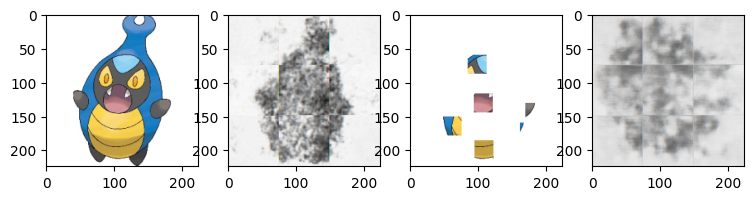

0.010238493792712688
0.024650821462273598
tensor([0.3846, 0.3983, 0.4496, 0.5040, 0.3679, 0.4036, 0.4215, 0.3721, 0.4703],
       device='cuda:6')
tensor([0.5299, 0.4953, 0.4931, 0.5426, 0.4638, 0.3603, 0.4590, 0.4213, 0.5311])
tensor([0.3346, 0.3223, 0.3535, 0.3755, 0.2982, 0.2581, 0.2992, 0.2649, 0.3952],
       device='cuda:6')


In [112]:
n+=5
model.eval()
o_model.eval()
print(n)
with torch.no_grad():
    in_img = test_tiles[n].reshape(3,224,224).unsqueeze(0).to(DEVICE)
    conv, _, pred, img_pred = model(in_img)
    box, _, base, conv2, pred2, img_pred2 = o_model(conv, in_img)

    print(box)
    fig, axes = plt.subplots(1, 4, figsize=(9, 3))

    axes[0].imshow(in_img.reshape(224,224,3).detach().cpu().numpy())
    
    axes[1].imshow(img_pred.reshape(224,224,3).detach().cpu().numpy())

    axes[2].imshow(base.reshape(224,224,3).detach().cpu().numpy())
    
    axes[3].imshow(img_pred2.reshape(224,224,3).detach().cpu().numpy())
    
    print(test_cluster[n])
    plt.show()
    print(loss(pred2,pred).item())
    print(loss(pred, te_cluster_dists[n].to(DEVICE)).item())
    print(pred2[0])
    print(te_cluster_dists[n])
    print(pred[0])

In [45]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_poke_d_model1.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_poke_o_model1.pickle"
torch.save(o_model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_poke_d_model1_backup.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_poke_o_model1_backup.pickle"
torch.save(o_model.state_dict(), SAVE_PATH)

In [488]:
o_model.eval()
with torch.no_grad():
    out = o_model(conv[169].unsqueeze(0))[0]
    print(out)

tensor([0.4961, 0.5171, 0.4878, 0.5181, 0.4893, 0.4994], device='cuda:7')


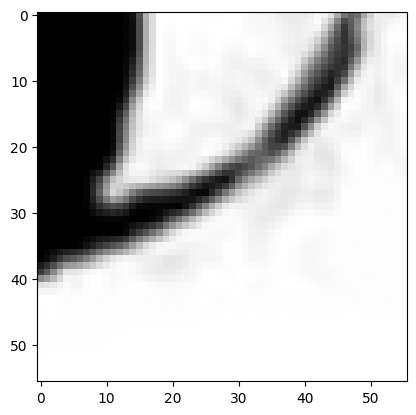

In [490]:
plt.imshow(test_tiles[169].reshape(56,56,3).detach().cpu().numpy())
plt.show()

In [491]:
base = torch.ones(56,56,3)
for o in out.reshape(3,2):
    x_min = int(o[0] * 56)
    y_min = int(o[1] * 56)
    x_max = x_min+14
    y_max = y_min+14
    base[x_min:x_max, y_min:y_max] = test_tiles[169][x_min:x_max, y_min:y_max]


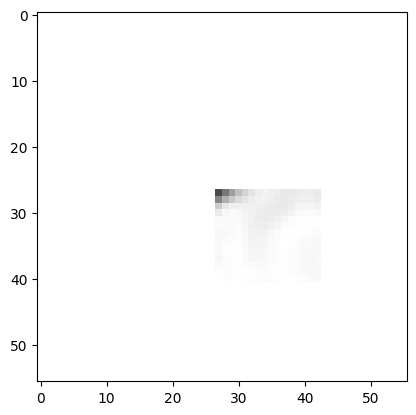

In [492]:
import matplotlib.patches as patches
plt.imshow(base.reshape(56,56,3).detach().cpu().numpy())

plt.show()

Epoch: 0


Train Loss: 2.6185691356658936
Test Loss: 0.013077893294394016

Epoch: 1
Train Loss: 4.466363310813904
Test Loss: 0.08383168280124664

Epoch: 2
Train Loss: 0.9857504367828369
Test Loss: 0.1306329220533371

Epoch: 3
Train Loss: 0.4335505776107311
Test Loss: 0.11838601529598236

Epoch: 4
Train Loss: 0.1894276663661003
Test Loss: 0.17145520448684692

Epoch: 5
Train Loss: 0.11076735612004995
Test Loss: 0.20163533091545105

Epoch: 6
Train Loss: 0.06546270055696368
Test Loss: 0.23045168817043304

Epoch: 7
Train Loss: 0.03978912718594074
Test Loss: 0.25447165966033936

Epoch: 8
Train Loss: 0.030275192810222507
Test Loss: 0.25443536043167114

Epoch: 9
Train Loss: 0.024784686043858528
Test Loss: 0.2580438256263733

Epoch: 10
Train Loss: 0.02040827041491866
Test Loss: 0.25746673345565796

Epoch: 11
Train Loss: 0.023005058988928795
Test Loss: 0.26734060049057007

Epoch: 12
Train Loss: 0.017401195713318884
Test Loss: 0.2632371783256531

Epoch: 13
Train Loss: 0.016578912502154708
Test Loss: 0.26046

In [ ]:
s_model = Discriminator(3, 128, 12)
s_model = s_model.to(DEVICE)
s_optimizer = torch.optim.Adam(s_model.parameters(), lr = LR)
loss = nn.MSELoss()

In [425]:
n=-1

In [426]:
n+=1
model.eval()
with torch.no_grad():
    out = model(train_tiles[n].reshape(3,56,56).to(DEVICE).unsqueeze(0))
    print(out)
    print(out.argmax())
    print(cluster_dists[n])
    print(cluster_dists[n].argmax())
    print(train_cluster[n])

tensor([[0.1761, 0.3635, 0.7116, 0.4861, 0.2940, 0.4402, 0.5499, 0.1935, 0.6286,
         0.5097, 0.4684, 0.3761]], device='cuda:7')
tensor(2, device='cuda:7')
tensor([0.1921, 0.3630, 0.7462, 0.5108, 0.3015, 0.4393, 0.5710, 0.2034, 0.6278,
        0.5121, 0.5224, 0.3982])
tensor(2)
tensor(0.)


In [427]:
n+=1
model.eval()
with torch.no_grad():
    out = model(test_tiles[n].reshape(3,56,56).to(DEVICE).unsqueeze(0))
    print(out)
    print(out.argmax())
    print(te_cluster_dists[n])
    print(te_cluster_dists[n].argmax())
    print(test_cluster[n])

tensor([[0.2593, 0.4116, 0.7252, 0.5696, 0.4040, 0.4303, 0.6239, 0.2999, 0.5534,
         0.5677, 0.5029, 0.3411]], device='cuda:7')
tensor(2, device='cuda:7')
tensor([0.2681, 0.4193, 0.7577, 0.5917, 0.4077, 0.4306, 0.6630, 0.3285, 0.6058,
        0.5836, 0.5645, 0.3457])
tensor(2)
tensor(0.)


In [16]:
print(train_tiles[tr_ind].shape)
print(train_cluster[tr_ind].shape)

torch.Size([100, 56, 56, 3])
torch.Size([100])


In [18]:
train_cluster[tr_ind]

tensor([ 0,  8,  4,  3,  1,  0,  2, 11,  2,  7,  1, 11,  5,  5, 11,  7, 10,  1,
         0,  5,  9, 10,  2,  6,  2,  2,  3,  8, 11, 10,  1,  2,  3,  0,  2,  0,
         2,  9,  2, 11, 10,  0,  1,  1,  2,  0,  2, 10,  0, 11,  2,  2, 10, 11,
        10,  1,  0,  9,  9,  7,  8,  3,  9,  8,  9,  6,  3,  1,  4,  5, 11, 11,
        11,  4,  2,  1,  1, 11, 10, 11,  0,  6,  1,  5,  4, 11,  5,  6,  2,  2,
         0,  0,  1,  7,  1, 11,  2,  1, 11,  1], dtype=torch.int32)